# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Project Setup

In [88]:
# all import statements needed for the project, for example:

import os
import re
from bs4 import BeautifulSoup
from pathlib import Path
from typing import List, Tuple, Dict, Optional
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import requests
import sqlalchemy as db

In [2]:
# any constants you might need; some have been added for you, and 
# some you need to fill in

TLC_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

TAXI_ZONES_DIR = "taxi_zones"
TAXI_ZONES_SHAPEFILE = f"{TAXI_ZONES_DIR}/taxi_zones.shp"
WEATHER_CSV_DIR = "weather_data"

CRS = 4326  # coordinate reference system

# (lat, lon)
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))
LGA_BOX_COORDS = ((40.763589, -73.891745), (40.778865, -73.854838))
JFK_BOX_COORDS = ((40.639263, -73.795642), (40.651376, -73.766264))
EWR_BOX_COORDS = ((40.686794, -74.194028), (40.699680, -74.165205))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [3]:
# Make sure the QUERY_DIRECTORY exists
try:
    os.mkdir(QUERY_DIRECTORY)
except Exception as e:
    if e.errno == 17:
        # the directory already exists
        pass
    else:
        raise

In [68]:
plt.style.use("seaborn-v0_8-muted")

## Part 1: Data Preprocessing

### Load Taxi Zones
In this section, we loaded the taxi shapefile that corresponds location IDs to geographical latitudes and logitudes. A dictionary named `ID_COORDS_DICT` is created to map Location IDs to tuples of latitude longitude.
* The `load_taxi_zones` function reads the shapefile and use GeoPandas to read the file
* The `lookup_coords_for_taxi_zone_id` function takes location IDs and the loaded shapefile and returns a tuple of latitude and logitude
* The `make_loc_id_coords_dict` creates a dictionary of location IDs and coordinates that will be used in data cleaning

In [74]:
def load_taxi_zones(shapefile: str) -> gpd.GeoDataFrame:
    """
    Load taxi zone shapefile data into a GeoDataFrame.

    Args:
        shapefile (str): Path to the shapefile containing taxi zone geographic data.

    Returns:
        gpd.GeoDataFrame: A GeoDataFrame containing the taxi zone data.
    """
    taxi_zones = gpd.read_file(shapefile)
    return taxi_zones

In [75]:
taxi_zones = load_taxi_zones(TAXI_ZONES_SHAPEFILE)
taxi_zones.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US survey foot)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [78]:
def lookup_coords_for_taxi_zone_id(zone_loc_id: int) -> Tuple[float, float]:
    """
    Lookup the geographic coordinates for a given taxi zone ID.

    Args:
        zone_loc_id (int): The unique LocationID

    Returns:
        Tuple[float, float]: A tuple of the form (latitude, longitude) of the centroid 
        of the specified taxi zone in the given CRS.
    """
    zone = taxi_zones[taxi_zones["LocationID"] == zone_loc_id]
    centroid = zone.geometry.centroid.iloc[0]
    centroid_geo = gpd.GeoSeries([centroid], crs=taxi_zones.crs).to_crs(epsg=CRS).iloc[0]

    latitude = centroid_geo.y
    longitude = centroid_geo.x

    return (latitude, longitude)

In [80]:
def make_loc_id_coords_dict(loaded_taxi_zones: gpd.GeoDataFrame) -> Dict[int, Tuple[float, float]]:
    """
    Create a dictionary mapping taxi zone LocationIDs to their geographic coordinates.

    Args:
        loaded_taxi_zones (gpd.GeoDataFrame).

    Returns:
        Dict[int, Tuple[float, float]]: A dictionary where keys are LocationIDs (int), 
        and values are tuples containing the latitude and longitude of the taxi zone centroids.
    """
    id_coords_dict = {}
    for loc_id in loaded_taxi_zones["LocationID"]:
        id_coords_dict[loc_id] = lookup_coords_for_taxi_zone_id(loc_id, loaded_taxi_zones)

    return id_coords_dict

In [96]:
ID_COORDS_DICT = make_loc_id_coords_dict(taxi_zones)

### Calculate Sample Size

In [81]:
def calculate_sample_size(population: int) -> int:
    """
    Calculate the sample size required for a given population size using Cochran's formula
    based on a specified confidence level, margin of error, and proportion. Then adjust the 
    sample size for a finite population.

    Args:
        population (int): Total population size.

    Returns:
        int: The calculated sample size.
    """
    confidence_level = 0.95
    margin_of_error = 0.05
    proportion = 0.5

    z_score = norm.ppf(1 - (1 - confidence_level) / 2)

    # Cochran’s
    n = (z_score**2 * proportion * (1 - proportion)) / (margin_of_error**2)
    
    # Adjust for finite population
    n_adj = n / (1 + (n - 1) / population)
    
    return int(round(n_adj)) 

### Common Functions
* `get_all_urls_from_taxi_page` fetches information on the taxi page and finds all "Yellow Taxi Trip Records" urls and "High Volume For-Hire Vehicle Trip Records" urls
* `find_parquet_urls` uses regex to filter the urls that ends with ".parquet" to make sure that the urls are parquet files
* `download_parquet` creates a directory and downloads relevant parquets into the directory
* `get_and_clean_month` filters the urls that are from January 2020 to August 2024
* `sample_monthly` function reads all the parquet files in a directory, finds the file with largest number of rows and computes the sample size using the "maximum population". Next it creates samples for all files using the computed sample size and combine them into a single dataframe.

In [82]:
def get_all_urls_from_taxi_page(taxi_page: str) -> Tuple[List[str], List[str]]:
    """
    Extract all URLs for Yellow Taxi and High Volume For-Hire Vehicle (FHVHV) trip records.

    Args:
        taxi_page (str): The URL of the taxi page to scrape.

    Returns:
        Tuple[List[str], List[str]]: A tuple containing two lists:
            - List containing URLs for Yellow Taxi trip records.
            - List containing URLs for High Volume For-Hire Vehicle (FHVHV) trip records.
    """
    response = requests.get(taxi_page)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    yellow_tags = soup.find_all("a", attrs={"title": "Yellow Taxi Trip Records"})
    fhvhv_tags = soup.find_all("a", attrs={"title": "High Volume For-Hire Vehicle Trip Records"})

    yellow_urls = [a["href"].strip() for a in yellow_tags]
    fhvhv_urls = [a["href"].strip() for a in fhvhv_tags]
    
    return yellow_urls, fhvhv_urls

In [84]:
def find_parquet_urls(urls: List[str]) -> List[str]:
    """
    Filters a list of URLs to return only Parquet file URLs.
    
    Args:
        urls (List[str]): A list of URLs.

    Returns:
        List[str]: A list containing with URLs that end with `.parquet`.
    """
    pattern = re.compile(r"\.parquet$")
    parquet_urls = [url for url in urls if pattern.search(url)]    
    return parquet_urls

In [85]:
def download_parquet(urls: List[str], output_dir: str) -> None:
    """
    Downloads Parquet files from a list of URLs and saves them to a specified directory.

    Args:
        urls (List[str]): List of URLs to download.
        output_dir (str): Directory where the downloaded files will be stored.
    """
    os.makedirs(output_dir, exist_ok=True)
    for url in urls:
        filename = os.path.basename(url)
        output_path = os.path.join(output_dir, filename)
        if os.path.exists(output_path):
            continue        
        response = requests.get(url, stream=True)
        with open(output_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=1024): 
                if chunk:
                    f.write(chunk)
        print(f"Downloaded {filename} to {output_dir}")

In [86]:
def get_and_clean_month(urls: List[str]) -> List[str]:
    """
    Filters a list of URLs to include URLs with dates between January 2020 and August 2024.

    Args:
        urls (List[str]): A list of URLs to filter.

    Returns:
        List[str]: A list of filtered URLs.
    """
    pattern = re.compile(r"(202[0-3]-(0[1-9]|1[0-2])|2024-(0[1-8]))")
    cleaned_urls = [url for url in urls if pattern.search(url)]
    return cleaned_urls

In [89]:
def read_parquet_to_df(directory: str) -> Optional[pd.DataFrame]:
    """
    Reads all Parquet files in a directory and concatenates them into a single DataFrame.

    Args:
        directory (str): Path to the directory containing the Parquet files to read.

    Returns:
        Optional[pd.DataFrame]: A combined DataFrame containing data from all Parquet files.
                                Returns None if no Parquet files are found.
    """
    
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".parquet")]
    all_dataframe = []
    for file in files:
        
        df = pd.read_parquet(file)
        all_dataframe.append(df)
    if all_dataframe:
        combined_df = pd.concat(all_dataframe, ignore_index=True)
        return combined_df

In [104]:
yellow_urls, fhvhv_urls = get_all_urls_from_taxi_page(TLC_URL)
taxi_parquet = find_parquet_urls(yellow_urls)
uber_parquet = find_parquet_urls(fhvhv_urls)
taxi_urls = get_and_clean_month(taxi_parquet)
uber_urls = get_and_clean_month(uber_parquet)

In [91]:
def calculate_monthly_sample_size(directory: str) -> int:
    """
    Calculates the sample size based on the largest number of rows in Parquet files 
    within a given directory.

    Args:
        directory (str): Path to the directory.

    Returns:
        int: The calculated sample size.
    """
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".parquet")]

    max_rows = 0
    for file in files:
        df = pd.read_parquet(file)
        max_rows = max(max_rows, df.shape[0])

    sample_size = calculate_sample_size(max_rows)
    print(f"Sample size for all months: {sample_size}")
    return sample_size

In [92]:
def sample_monthly(directory: str, sample_size: int) -> List[pd.DataFrame]:
    """
    Samples a specified number of rows from each Parquet file in a directory.

    Args:
        directory (str): Path to the directory containing Parquet files.
        sample_size (int): Number of rows to sample from each file.

    Returns:
        List[pd.DataFrame]: A list of sampled DataFrames for each month.
    """
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".parquet")]
    sampled_dataframes = []

    for file in files:
        df = pd.read_parquet(file)
        sampled_df = df.sample(n=sample_size, random_state=30, replace=False)
        sampled_dataframes.append(sampled_df)

    print("Finished sampling")
    return sampled_dataframes

### Process Taxi Data

In [116]:
taxi_data_dir = "taxi_data"
download_parquet(taxi_urls, taxi_data_dir)

In [108]:
taxi_sample_size = calculate_monthly_sample_size(taxi_data_dir)

taxi data sample size: 384


In [117]:
taxi_monthly_sampled = sample_monthly(taxi_data_dir, taxi_sample_size * 2)

Finished sampling


In [181]:
def get_and_clean_taxidata(dataframes: List[pd.DataFrame]) -> pd.DataFrame:
    """
    Cleans a list of taxi DataFrames, resamples them based on taxi_sample_size,
    and concatenates them into one DataFrame.

    Args:
        dataframes (List[pd.DataFrame]): List of taxi DataFrames to be cleaned and sampled.
        taxi_sample_size (int): Number of samples to keep for each DataFrame.

    Returns:
        pd.DataFrame: A cleaned and concatenated DataFrame of sampled taxi data.
    """
    try:
        print(f"Cleaning and sampling the list of dataframes...")

        cleaned_sampled_dataframes = []

        for dataframe in dataframes:
            if not isinstance(dataframe, pd.DataFrame):
                raise ValueError("Each item in the list must be a Pandas DataFrame.")

            # Look up latitude and longitude (get those coordinates)
            dataframe[["latitude_pickup", "longitude_pickup"]] = dataframe["PULocationID"].map(ID_COORDS_DICT).apply(pd.Series)
            dataframe[["latitude_dropoff", "longitude_dropoff"]] = dataframe["DOLocationID"].map(ID_COORDS_DICT).apply(pd.Series)

            # Remove invalid location IDs and where distance is 0
            dataframe = dataframe.dropna(subset=["latitude_pickup", "longitude_pickup", "latitude_dropoff", "longitude_dropoff"])
            dataframe = dataframe[dataframe["trip_distance"] > 0]

            # Normalize column names
            dataframe.columns = [col.lower().replace(" ", "_") for col in dataframe.columns]

            # Normalize and use appropriate column types
            dataframe["tpep_pickup_datetime"] = pd.to_datetime(dataframe["tpep_pickup_datetime"])
            dataframe["tpep_dropoff_datetime"] = pd.to_datetime(dataframe["tpep_dropoff_datetime"])

            # Filter trips within New York bounding box
            lat_min, lon_min = NEW_YORK_BOX_COORDS[0]
            lat_max, lon_max = NEW_YORK_BOX_COORDS[1]
            dataframe = dataframe[
                (dataframe["latitude_pickup"].between(lat_min, lat_max)) &
                (dataframe["longitude_pickup"].between(lon_min, lon_max)) &
                (dataframe["latitude_dropoff"].between(lat_min, lat_max)) &
                (dataframe["longitude_dropoff"].between(lon_min, lon_max))
            ]

            # Resample the cleaned DataFrame
            sampled_dataframe = dataframe.sample(n=taxi_sample_size, random_state=30, replace=False)
            cleaned_sampled_dataframes.append(sampled_dataframe)

        # Concatenate all sampled DataFrames
        if cleaned_sampled_dataframes:
            final_dataframe = pd.concat(cleaned_sampled_dataframes, ignore_index=True)

            # Combine "airport_fee" with "Airport_fee"
            if "Airport_fee" in final_dataframe.columns:
                final_dataframe["airport_fee"] = final_dataframe["Airport_fee"].combine_first(final_dataframe["airport_fee"])
                final_dataframe.drop(columns=["Airport_fee"], inplace=True)
            final_dataframe["airport_fee"] = final_dataframe["airport_fee"].fillna(0)

            # Calculate fares
            surcharge_columns = ["extra", "improvement_surcharge", "congestion_surcharge", "airport_fee"]
            final_dataframe[surcharge_columns] = final_dataframe[surcharge_columns].fillna(0)
            final_dataframe["total_surcharge"] = final_dataframe[surcharge_columns].sum(axis=1)
            final_dataframe["total_money"] = (final_dataframe["fare_amount"] 
                                            + final_dataframe["total_surcharge"] 
                                            + final_dataframe["mta_tax"] 
                                            + final_dataframe["tolls_amount"])

            # Remove unnecessary columns
            columns_to_keep = [
                "tpep_pickup_datetime",
                "trip_distance",
                "latitude_pickup", "longitude_pickup", "latitude_dropoff", "longitude_dropoff",
                "fare_amount", "total_surcharge", "mta_tax", "tolls_amount", "total_money", 
                "tip_amount"
            ]
            final_dataframe = final_dataframe[columns_to_keep]
            return final_dataframe

    except Exception as e:
        print(f"Error processing the dataframes: {e}")
        return pd.DataFrame()

In [182]:
taxi_data = get_and_clean_taxidata(taxi_monthly_sampled)

Cleaning and sampling the list of dataframes...


/var/folders/rm/llw7py457rl4zlvsw5ymljw80000gn/T/ipykernel_54357/2780130706.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_dataframe = pd.concat(cleaned_sampled_dataframes, ignore_index=True)


In [183]:
taxi_data.head()

,tpep_pickup_datetime,trip_distance,latitude_pickup,longitude_pickup,latitude_dropoff,longitude_dropoff,fare_amount,total_surcharge,mta_tax,tolls_amount,total_money,tip_amount
0,2023-06-23 07:44:31,2.90,40.780436,-73.957012,40.753513,-73.988787,16.3,6.0,0.5,0.0,22.8,4.05
1,2023-06-07 15:52:08,0.95,40.756688,-73.972356,40.756729,-73.965146,10.7,3.5,0.5,0.0,14.7,2.94
2,2023-06-09 11:20:16,1.50,40.723888,-74.001538,40.735035,-74.008984,12.1,3.5,0.5,0.0,16.1,0.00
3,2023-06-07 19:14:34,1.52,40.756729,-73.965146,40.778766,-73.951010,10.0,6.0,0.5,0.0,16.5,3.30
4,2023-06-21 07:33:32,1.98,40.780436,-73.957012,40.801169,-73.937346,12.1,3.5,0.5,0.0,16.1,0.00


In [184]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21504 entries, 0 to 21503
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tpep_pickup_datetime  21504 non-null  datetime64[us]
 1   trip_distance         21504 non-null  float64       
 2   latitude_pickup       21504 non-null  float64       
 3   longitude_pickup      21504 non-null  float64       
 4   latitude_dropoff      21504 non-null  float64       
 5   longitude_dropoff     21504 non-null  float64       
 6   fare_amount           21504 non-null  float64       
 7   total_surcharge       21504 non-null  float64       
 8   mta_tax               21504 non-null  float64       
 9   tolls_amount          21504 non-null  float64       
 10  total_money           21504 non-null  float64       
 11  tip_amount            21504 non-null  float64       
dtypes: datetime64[us](1), float64(11)
memory usage: 2.0 MB


In [185]:
taxi_data.describe()

,tpep_pickup_datetime,trip_distance,latitude_pickup,longitude_pickup,latitude_dropoff,longitude_dropoff,fare_amount,total_surcharge,mta_tax,tolls_amount,total_money,tip_amount
count,21504,21504.000000,21504.000000,21504.000000,21504.000000,21504.000000,21504.000000,21504.000000,21504.000000,21504.000000,21504.000000,21504.000000
mean,2022-05-01 21:59:40.056175,3.269402,40.753699,-73.967116,40.755572,-73.970761,15.170968,4.022128,0.490565,0.445686,20.129347,2.731694
min,2020-01-01 01:12:27,0.010000,40.576961,-74.174002,40.576961,-74.174002,-171.700000,-10.250000,-0.500000,-15.380000,-188.080000,0.000000
25%,2021-02-28 23:29:18.500000,1.100000,40.740439,-73.989845,40.740337,-73.989845,7.200000,2.800000,0.500000,0.000000,11.800000,0.000000
50%,2022-05-01 03:11:49,1.800000,40.758028,-73.977698,40.758028,-73.977698,10.700000,3.500000,0.500000,0.000000,15.400000,2.160000
75%,2023-06-30 23:37:11.500000,3.400000,40.773633,-73.961764,40.775932,-73.959635,17.470000,5.300000,0.500000,0.000000,22.050000,3.460000
max,2024-08-31 23:36:19,55.600000,40.899528,-73.735554,40.899528,-73.726655,124.100000,17.000000,0.800000,40.000000,141.540000,111.000000
std,NaN,4.058293,0.031836,0.044630,0.033238,0.036692,13.986222,2.043420,0.089441,1.865712,15.737372,3.279768


### Processing Uber Data
This section downloads the relevant parquet files from the taxi website and creates a sample according to the sampling function of the Uber data. The sample dataframe is cleaned using the `get_and_clean_uber_data` function.

* The `filter_uber_and_sample_monthly` function uses similar logic as the `sample_monthly` function, but it filters Uber trips before sampling. The function first calculates the appropriate sample size with the filtered Uber data. It reads parquet files in the directory and filter Uber data each month, then creates a sample of each month and integrate the sample datasets into one dataset.

* The `get_and_clean_uber_data` function takes a dataframe and returns a cleaned dataframe that:
    * Filtered Uber rides
    * Converted Location IDs to latitude lognitude coordinates
    * Computed total fares for each ride
    * Filtered rides that start and/or end within the New York bounding box
    * Dropped columns that are irrelevant to later parts of the project
    * Normalized column names and removed invalid data

In [140]:
uber_data_dir = "uber_data"
download_parquet(uber_urls, uber_data_dir)

In [93]:
def uber_monthly_sample_size(directory: str) -> int:
    """
    Calculates the sample size based on the largest number of Uber rides (filtered from FHVHV data)
    in Parquet files within the directory.

    Args:
        directory (str): Path to the directory containing Parquet files.

    Returns:
        int: The calculated sample size.
    """
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".parquet")]

    max_rows = 0
    for file in files:
        # only read relevant columns for faster filtering
        df = pd.read_parquet(file, columns=["hvfhs_license_num"])
        filtered_df = df[df["hvfhs_license_num"] == "HV0003"]
        max_rows = max(max_rows, filtered_df.shape[0])

    sample_size = calculate_sample_size(max_rows)
    print(f"Sample size for all months: {sample_size}")

    return sample_size

In [170]:
def uber_sample_monthly(directory: str, sample_size: int) -> List[pd.DataFrame]:
    """
    Samples a specified number of rows from each Parquet file in a directory filtering Uber data only.

    Args:
        directory (str): Path to the directory containing Parquet files.
        sample_size (int): Number of rows to sample from each file.

    Returns:
        List[pd.DataFrame]: A list of sampled DataFrames for each month.
    """
    files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".parquet")]
    sampled_dataframes = []
    columns_to_load = ["hvfhs_license_num", "pickup_datetime", "dropoff_datetime", 
               "PULocationID", "DOLocationID", "trip_miles",
               "base_passenger_fare", "bcf", "congestion_surcharge", "airport_fee", "sales_tax", "tolls", "tips", 
    ]
    
    for file in files:
        df = pd.read_parquet(file, columns=columns_to_load)
        filtered_df = df[df["hvfhs_license_num"] == "HV0003"]
        sampled_df = filtered_df.sample(n=sample_size, random_state=30, replace=False)
        sampled_dataframes.append(sampled_df)

    print("Finished sampling")
    return sampled_dataframes

In [171]:
uber_sample_size = uber_monthly_sample_size(uber_data_dir)
uber_monthly_sampled = uber_sample_monthly(uber_data_dir, uber_sample_size * 2)

Sample size for all months: 384
Finished sampling


In [186]:
def get_and_clean_uber_data(dataframes: List[pd.DataFrame]) -> pd.DataFrame:
    """
    Cleans a list of Uber DataFrames, resamples them based on uber_sample_size,
    and concatenates them into one DataFrame.

    Args:
        dataframes (List[pd.DataFrame]): List of Uber DataFrames to be cleaned and sampled.
        taxi_sample_size (int): Number of samples to keep for each DataFrame.

    Returns:
        pd.DataFrame: A cleaned and concatenated DataFrame of sampled Uber data.
    """
    
    surcharge_columns = ["bcf", "congestion_surcharge", "airport_fee"]
    fare_columns = ["base_passenger_fare", "sales_tax", "tolls"] + surcharge_columns
    columns_to_keep = fare_columns + ["pickup_lat", "pickup_lon", "dropoff_lat", "dropoff_lon"]
    try:
        print(f"Cleaning and sampling the list of dataframes...")

        cleaned_sampled_dataframes = []
        for df in dataframes:
            # convert LocationID to coordinates
            df[["pickup_lat", "pickup_lon"]] = df["PULocationID"].map(ID_COORDS_DICT).apply(pd.Series)
            df[["dropoff_lat", "dropoff_lon"]] = df["DOLocationID"].map(ID_COORDS_DICT).apply(pd.Series)
            
            # remove invalid locations & 0 mile trips
            df = df.dropna(subset=["pickup_lat", "pickup_lon", "dropoff_lat", "dropoff_lon"])
            df = df[df["trip_miles"] != 0]
            
            # filter trips within the bounding box
            ((min_lat, min_lon), (max_lat, max_lon)) = NEW_YORK_BOX_COORDS
            pickup_in_box = (
                (df["pickup_lat"] >= min_lat) & (df["pickup_lat"] <= max_lat) &
                (df["pickup_lon"] >= min_lon) & (df["pickup_lon"] <= max_lon)
            )
            dropoff_in_box = (
                (df["dropoff_lat"] >= min_lat) & (df["dropoff_lat"] <= max_lat) &
                (df["dropoff_lon"] >= min_lon) & (df["dropoff_lon"] <= max_lon)
            )
            df = df[pickup_in_box & dropoff_in_box]
            
            
        
            # Resample the cleaned DataFrame
            sampled_df = df.sample(n=uber_sample_size, random_state=30, replace=False)
            cleaned_sampled_dataframes.append(sampled_df)
        
        # Combine resampled DataFrames
        if cleaned_sampled_dataframes:
            columns_to_keep = ["pickup_datetime", 
                               "pickup_lat", "pickup_lon", "dropoff_lat", "dropoff_lon",
                               "trip_miles", 
                               "base_passenger_fare", "total_surcharge", "sales_tax", "tolls", "total_fare",
                               "tips"]
            final_df = pd.concat(cleaned_sampled_dataframes, ignore_index=True)
            
            # compute fares
            final_df[surcharge_columns] = final_df[surcharge_columns].fillna(0)
            final_df["total_surcharge"] = final_df[surcharge_columns].sum(axis=1)
            final_df[fare_columns] = final_df[fare_columns].fillna(0)
            final_df["total_fare"] = final_df[fare_columns].sum(axis=1)
            final_df = final_df[columns_to_keep]
            return final_df

    except Exception as e:
        print(f"Error processing the dataframes: {e}")
        return pd.DataFrame()

In [187]:
uber_data = get_and_clean_uber_data(uber_monthly_sampled)

Cleaning and sampling the list of dataframes...


/var/folders/rm/llw7py457rl4zlvsw5ymljw80000gn/T/ipykernel_54357/2840169793.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(cleaned_sampled_dataframes, ignore_index=True)


In [188]:
uber_data.head(10)

,pickup_datetime,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,trip_miles,base_passenger_fare,total_surcharge,sales_tax,tolls,total_fare,tips
0,2021-03-20 23:39:58,40.877137,-73.879022,40.846783,-73.850671,3.42,14.16,0.42,1.26,0.00,15.84,0.00
1,2021-03-05 13:48:03,40.823318,-73.823539,40.832101,-73.848641,2.41,13.30,0.40,1.18,0.00,14.88,0.00
2,2021-03-24 20:02:36,40.740337,-73.990458,40.748575,-73.985156,1.09,12.77,3.15,1.17,0.00,17.09,1.00
3,2021-03-13 10:16:55,40.718337,-73.880051,40.723995,-73.902331,2.43,9.32,0.28,0.83,0.00,10.43,0.00
4,2021-03-02 07:42:37,40.757312,-73.885317,40.777427,-73.905407,2.56,10.35,0.31,0.92,0.00,11.58,0.00
5,2021-03-29 18:47:42,40.728340,-73.997380,40.780436,-73.957012,4.71,39.29,3.93,3.49,0.00,46.71,4.67
6,2021-03-02 17:55:28,40.729506,-73.949540,40.748497,-73.992438,4.18,21.08,3.57,2.41,6.12,33.18,4.97
7,2021-03-14 22:52:33,40.703546,-73.875737,40.718337,-73.880051,1.54,8.33,0.25,0.74,0.00,9.32,0.00
8,2021-03-11 13:13:07,40.614591,-73.915277,40.637900,-73.960968,4.06,30.42,0.91,2.70,0.00,34.03,0.00
9,2021-03-28 10:52:50,40.849058,-73.905122,40.854405,-73.854394,3.44,14.94,0.45,1.33,0.00,16.72,0.00


In [189]:
uber_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21504 entries, 0 to 21503
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   pickup_datetime      21504 non-null  datetime64[us]
 1   pickup_lat           21504 non-null  float64       
 2   pickup_lon           21504 non-null  float64       
 3   dropoff_lat          21504 non-null  float64       
 4   dropoff_lon          21504 non-null  float64       
 5   trip_miles           21504 non-null  float64       
 6   base_passenger_fare  21504 non-null  float64       
 7   total_surcharge      21504 non-null  float64       
 8   sales_tax            21504 non-null  float64       
 9   tolls                21504 non-null  float64       
 10  total_fare           21504 non-null  float64       
 11  tips                 21504 non-null  float64       
dtypes: datetime64[us](1), float64(11)
memory usage: 2.0 MB


In [191]:
uber_data.describe()

,pickup_datetime,pickup_lat,pickup_lon,dropoff_lat,dropoff_lon,trip_miles,base_passenger_fare,total_surcharge,sales_tax,tolls,total_fare,tips
count,21504,21504.000000,21504.000000,21504.000000,21504.000000,21504.000000,21504.000000,21504.000000,21504.000000,21504.000000,2.150400e+04,21504.000000
mean,2022-05-02 01:20:32.941731,40.738377,-73.933782,40.737939,-73.933268,4.431483,21.216328,1.804562,1.907293,0.668083,2.559626e+01,0.788692
min,2020-01-01 00:10:59,40.561994,-74.186421,40.561994,-74.186421,0.020000,-15.950000,0.000000,0.000000,0.000000,-1.332268e-15,0.000000
25%,2021-02-28 23:53:05,40.691507,-73.984052,40.690787,-73.983025,1.540000,10.570000,0.340000,0.920000,0.000000,1.254000e+01,0.000000
50%,2022-05-01 00:57:50,40.739495,-73.947442,40.737698,-73.946510,2.820000,16.610000,0.740000,1.470000,0.000000,1.980500e+01,0.000000
75%,2023-07-01 00:10:12.500000,40.775965,-73.898957,40.775932,-73.895364,5.630000,26.520000,3.300000,2.380000,0.000000,3.187250e+01,0.000000
max,2024-08-31 23:41:13,40.899528,-73.726655,40.899528,-73.726655,61.240000,249.520000,14.240000,26.580000,47.480000,3.378200e+02,41.360000
std,NaN,0.068720,0.064695,0.068818,0.067466,4.379942,15.864395,1.738572,1.488522,2.529564,1.969785e+01,2.405212


### Processing Weather Data
In this section, we processed the weather data and creates dataframes with hourly and daily granularity information retaining relevant information only.
*  `get_all_weather_csvs` returns the weather csv files in the directory
*  `clean_month_weather_data_hourly` takes csv files and returns a dataframe that contains hourly precipation and hourly wind speed information:
    * The columns and data were converted to appropriate data types, as listed in the docstring
    * In the original data, some entries in `HourlyPrecipitation` are "T" representing trace of rain that is less than 0.01 inch. When cleaning data, "T" were replaced with 0.005, which is the mean value of 0.01 and 0.
    * Normalized column names for readability
    * Filled in missing entries
*  `clean_month_weather_data_daily` takes csv files and returns a dataframe that contains daily precipation, wind speed, and snowfall information.
    * "T" in `DailyPrecipitation` and `DailySnowfall` were replaced with 0.005, similar to hourly data cleaning
*  `load_and_clean_weather_data` concatnates all daily dataframes and all hourly dataframes into two large dataframes that contains all daily weather data and all hourly data respectively.

In [94]:
def get_all_weather_csvs(directory: str) -> list:
    """
    Gets all CSV files from a specified directory.

    Args:
        directory (str): Path to the directory containing weather CSV files.

    Returns:
        list: A list of file paths to all CSV files.
    """    
    weather_csvs = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.csv')]
    return weather_csvs

In [95]:
def clean_month_weather_data_hourly(csv_file: str) -> pd.DataFrame:
    """
    Cleans hourly weather data from a CSV file.

    This function processes a CSV file containing hourly weather data by:
    - Converting the "DATE" column to datetime format.
    - Replacing trace precipitation values ("T") with a small numeric value.
    - Extracting numeric values from the 'HourlyPrecipitation' column, converting them to float.
    - Selecting and renaming relevant columns.
    - Filling missing values with zeros.

    Args:
        csv_file (str): Path to the CSV file containing hourly weather data.

    Returns:
        pd.DataFrame: A cleaned DataFrame with columns:"date", "hourly_precipitation", "hourly_wind_speed" 
    """
    df = pd.read_csv(csv_file, low_memory=False)
    
    df["date"] = pd.to_datetime(df["DATE"])
    df["HourlyPrecipitation"] = (df["HourlyPrecipitation"]
        .replace("T", "0.005")  # Replace 'T' (trace) with a small float
        .str.extract(r"([\d\.]+)")  # Extract numeric part, ignore non-numeric
        .astype(float)  # Convert to float
    )

    columns = ["date", "HourlyPrecipitation", "HourlyWindSpeed"]
    df = df[columns]
    
    df = df.dropna(subset=["date"])
    df.fillna(0, inplace=True)
    rename_map = {
        "HourlyPrecipitation": "hourly_precipitation",
        "HourlyWindSpeed": "hourly_wind_speed",
    }
    df = df.rename(columns=rename_map)

    return df

In [96]:
def clean_month_weather_data_daily(csv_file: str) -> pd.DataFrame:
    """
    Cleans daily weather data from a CSV file.

    This function processes a CSV file containing daily weather data by:
    - Converting the "DATE" column to datetime format.
    - Replacing trace precipitation and snowfall values ("T") with a small numeric value.
    - Extracting numeric values from the "DailyPrecipitation" and "DailySnowfall" columns and converting them to float.
    - Selecting and renaming relevant columns.
    - Dropping rows with missing values in the specified columns.

    Args:
        csv_file (str): Path to the CSV file containing daily weather data.

    Returns:
        pd.DataFrame: A cleaned DataFrame with columns: "date", "daily_precipitation",
        "daily_average_wind_speed", "daily_snowfall"
    """
    df = pd.read_csv(csv_file, low_memory=False)
    df["date"] = pd.to_datetime(df["DATE"])

    df["DailyPrecipitation"] = (df["DailyPrecipitation"]
            .replace("T", "0.005")  
            .str.extract(r"([\d\.]+)")  
            .astype(float)  
    )
    df["DailySnowfall"] = (df["DailySnowfall"]
            .replace("T", "0.005")  
            .str.extract(r"([\d\.]+)")  
            .astype(float) 
    )
    
    columns = ["date", "DailyPrecipitation", "DailyAverageWindSpeed", "DailySnowfall"]
    df = df[columns]
    df = df.dropna(subset=columns)
    
    rename_map = {
        "DailyPrecipitation": "daily_precipitation",
        "DailyAverageWindSpeed": "daily_average_wind_speed",
        "DailySnowfall": "daily_snowfall",
    }
    df = df.rename(columns=rename_map)

    return df

In [97]:
def load_and_clean_weather_data() -> (pd.DataFrame, pd.DataFrame):
    """
    Load and clean weather data from CSV files.
    - Retrieves all weather-related CSV files from the WEATHER_CSV_DIR.
    - Cleans the hourly and daily data separately using respective cleaning functions.
    - Combines cleaned data into two DataFrames: one for hourly data and one for daily data.

    Returns:
        tuple: A tuple containing hourly_data and daily_data
    """   
    weather_csv_files = get_all_weather_csvs(WEATHER_CSV_DIR)
    
    hourly_dataframes = []
    daily_dataframes = []
        
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    
    return hourly_data, daily_data

In [208]:
hourly_weather_data, daily_weather_data = load_and_clean_weather_data()

In [209]:
hourly_weather_data.head()

,date,hourly_precipitation,hourly_wind_speed
0,2020-01-01 00:51:00,0.0,8.0
1,2020-01-01 01:51:00,0.0,8.0
2,2020-01-01 02:51:00,0.0,14.0
3,2020-01-01 03:51:00,0.0,11.0
4,2020-01-01 04:51:00,0.0,6.0


In [210]:
hourly_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56098 entries, 0 to 11638
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  56098 non-null  datetime64[ns]
 1   hourly_precipitation  56098 non-null  float64       
 2   hourly_wind_speed     56098 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.7 MB


In [211]:
hourly_weather_data.describe()

,date,hourly_precipitation,hourly_wind_speed
count,56098,56098.000000,56098.000000
mean,2022-05-29 21:14:19.618881024,0.010841,4.537238
min,2020-01-01 00:51:00,0.000000,0.000000
25%,2021-03-18 19:01:45,0.000000,0.000000
50%,2022-05-28 01:21:00,0.000000,5.000000
75%,2023-08-15 05:39:00,0.000000,7.000000
max,2024-10-22 18:51:00,3.470000,2237.000000
std,NaN,0.056735,13.883208


In [217]:
daily_weather_data.head()

,date,daily_precipitation,daily_average_wind_speed,daily_snowfall
24,2020-01-01 23:59:00,0.000,8.6,0.0
49,2020-01-02 23:59:00,0.000,5.4,0.0
86,2020-01-03 23:59:00,0.150,3.4,0.0
144,2020-01-04 23:59:00,0.270,4.4,0.0
169,2020-01-05 23:59:00,0.005,11.3,0.0


In [218]:
daily_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1692 entries, 24 to 11637
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      1692 non-null   datetime64[ns]
 1   daily_precipitation       1692 non-null   float64       
 2   daily_average_wind_speed  1692 non-null   float64       
 3   daily_snowfall            1692 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 66.1 KB


In [219]:
daily_weather_data.describe()

,date,daily_precipitation,daily_average_wind_speed,daily_snowfall
count,1692,1692.000000,1692.000000,1692.000000
mean,2022-06-11 16:53:28.085106176,0.145018,5.000355,0.040721
min,2020-01-01 23:59:00,0.000000,0.600000,0.000000
25%,2021-04-05 17:59:00,0.000000,3.200000,0.000000
50%,2022-06-19 11:59:00,0.000000,4.600000,0.000000
75%,2023-08-16 05:59:00,0.060000,6.325000,0.000000
max,2024-10-21 23:59:00,7.130000,14.200000,14.800000
std,NaN,0.420440,2.339679,0.502493


## Part 2: Storing Cleaned Data

In [4]:
engine = db.create_engine(DATABASE_URL)

In [227]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather(
    id INTEGER PRIMARY KEY,
    date DATETIME,
    hourly_precipitation FLOAT,
    hourly_wind_speed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather(
    id INTEGER PRIMARY KEY,
    date DATETIME,
    daily_precipitation FLOAT,
    daily_average_wind_speed FLOAT,
    daily_snowfall FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips(
     tpep_pickup_datetime DATETIME, 
     trip_distance FLOAT, 
     latitude_pickup FLOAT, 
     longitude_pickup FLOAT, 
     latitude_dropoff FLOAT, 
     longitude_dropoff FLOAT, 
     fare_amount FLOAT, 
     total_surcharge FLOAT, 
     mta_tax FLOAT, 
     tolls_amount FLOAT, 
     total_money FLOAT,
     tip_amount FLOAT
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips(
    pickup_datetime DATETIME,
    pickup_lat FLOAT,
    pickup_lon FLOAT,
    dropoff_lat FLOAT,
    dropoff_lon FLOAT,
    trip_miles FLOAT,
    base_passenger_fare FLOAT,
    total_surcharge FLOAT,
    sales_tax FLOAT,
    tolls FLOAT,
    total_fare FLOAT,
    tips FLOAT
);
"""

In [228]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [229]:
# create the tables with the schema files
with engine.connect() as connection:
    with open(DATABASE_SCHEMA_FILE, "r") as f:
        schema_sql = f.read()
    schema_stmts = [stmt.strip() for stmt in schema_sql.split(";") if stmt.strip()]
    for stmt in schema_stmts:
        connection.execute(db.text(stmt))

### Add Data to Database

In [230]:
def write_dataframes_to_table(table_to_df_dict):
    with engine.connect() as connection:
        for table_name, df in table_to_df_dict.items():
            
            df.to_sql(table_name, con=connection, if_exists='replace', index=False)

In [231]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather_data,
    "daily_weather": daily_weather_data,
}

In [232]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

In [11]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    query_filepath = os.path.join(QUERY_DIRECTORY, outfile)
    with open(query_filepath, 'w') as f:
        f.write(query)

### Query 1

In [12]:
QUERY_1_FILENAME = "taxi_most_popular_hour.sql"

QUERY_1 = """
SELECT 
    strftime('%H', tpep_pickup_datetime) AS hour,
    COUNT(*) AS ride_count
FROM 
    taxi_trips
WHERE 
    tpep_pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY 
    hour
ORDER BY 
    ride_count DESC;
"""

In [13]:
# execute query either via sqlalchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_1)).fetchall()
results

# or via pandas
df_results1 = pd.read_sql(QUERY_1, con=engine)

In [14]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

In [15]:
print(df_results1)

   hour  ride_count
0    17        1537
1    18        1526
2    15        1437
3    16        1401
4    19        1377
5    14        1356
6    13        1282
7    12        1218
8    11        1129
9    20        1124
10   21        1086
11   10        1068
12   09         982
13   22         978
14   08         824
15   23         754
16   07         646
17   00         488
18   06         358
19   01         326
20   02         206
21   03         149
22   05         132
23   04         105


### Query 2

In [239]:
QUERY_2_FILENAME = "uber_most_popular_day.sql"

QUERY_2 = """
SELECT 
    strftime('%w', pickup_datetime) AS day_of_week,  -- 0 = Sunday, 6 = Saturday
    COUNT(*) AS ride_count
FROM 
    uber_trips
WHERE 
    pickup_datetime BETWEEN '2020-01-01' AND '2024-08-31'
GROUP BY 
    day_of_week
ORDER BY 
    ride_count DESC;
"""

In [240]:
# execute query either via sqlalchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_2)).fetchall()
results

# or via pandas
df_results2 = pd.read_sql(QUERY_2, con=engine)

In [241]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

In [242]:
print(df_results2)

  day_of_week  ride_count
0           6        3534
1           5        3441
2           4        3073
3           0        3046
4           3        2960
5           2        2809
6           1        2625


### Query 3

In [243]:
QUERY_3_FILENAME = "jan_per_distance.sql"

QUERY_3 = """
SELECT 
    trip_distance
FROM (
    SELECT 
        CAST(trip_distance AS FLOAT) AS trip_distance
    FROM taxi_trips 
    WHERE tpep_pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
    
    UNION ALL
    
    SELECT 
        CAST(trip_miles AS FLOAT) AS trip_distance
    FROM uber_trips 
    WHERE pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
) AS combined_results
WHERE trip_distance IS NOT NULL
ORDER BY trip_distance
LIMIT 1 OFFSET (
    SELECT CAST(COUNT(*) * 0.95 AS INTEGER) 
    FROM (
        SELECT 
            CAST(trip_distance AS FLOAT) AS trip_distance
        FROM taxi_trips 
        WHERE tpep_pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
        
        UNION ALL
        
        SELECT 
            CAST(trip_miles AS FLOAT) AS trip_distance
        FROM uber_trips 
        WHERE pickup_datetime BETWEEN '2024-01-01' AND '2024-01-31'
    )
) - 1;
"""


In [244]:
# execute query either via sqlalchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_3)).fetchall()
results

# or via pandas
df_results3 = pd.read_sql(QUERY_3, con=engine)

In [245]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

In [246]:
print(df_results3)

   trip_distance
0          12.17


### Query 4

In [130]:
QUERY_4_FILENAME = "top10_busiest_day.sql"

QUERY_4 = """
WITH combined_rides AS (
    SELECT 
        DATE(tpep_pickup_datetime) AS trip_date,
        COUNT(*) AS total_rides,
        AVG(trip_distance) AS avg_distance
    FROM taxi_trips
    WHERE tpep_pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
    GROUP BY trip_date

    UNION ALL

    SELECT 
        DATE(pickup_datetime) AS trip_date,
        COUNT(*) AS total_rides,
        AVG(trip_miles) AS avg_distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
    GROUP BY trip_date
),
daily_stats AS (
    SELECT
        trip_date,
        SUM(total_rides) AS total_rides,
        AVG(avg_distance) AS avg_distance
    FROM combined_rides
    GROUP BY trip_date
)
SELECT 
    ds.trip_date,
    ds.total_rides,
    ds.avg_distance,
    dw.daily_precipitation AS avg_precipitation,
    dw.daily_average_wind_speed AS avg_wind_speed
FROM daily_stats ds
LEFT JOIN daily_weather dw ON ds.trip_date = DATE(dw.date)
ORDER BY ds.total_rides DESC
LIMIT 10;
"""

In [131]:
# execute query either via sqlalchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_4)).fetchall()
results

# or via pandas
df_results4 = pd.read_sql(QUERY_4, con=engine)

OperationalError: (sqlite3.OperationalError) no such column: dw.date
[SQL: 
WITH combined_rides AS (
    SELECT 
        DATE(tpep_pickup_datetime) AS trip_date,
        COUNT(*) AS total_rides,
        AVG(trip_distance) AS avg_distance
    FROM taxi_trips
    WHERE tpep_pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
    GROUP BY trip_date

    UNION ALL

    SELECT 
        DATE(pickup_datetime) AS trip_date,
        COUNT(*) AS total_rides,
        AVG(trip_miles) AS avg_distance
    FROM uber_trips
    WHERE pickup_datetime BETWEEN '2023-01-01' AND '2023-12-31'
    GROUP BY trip_date
),
daily_stats AS (
    SELECT
        trip_date,
        SUM(total_rides) AS total_rides,
        AVG(avg_distance) AS avg_distance
    FROM combined_rides
    GROUP BY trip_date
)
SELECT 
    ds.trip_date,
    ds.total_rides,
    ds.avg_distance,
    dw.daily_precipitation AS avg_precipitation,
    dw.daily_average_wind_speed AS avg_wind_speed
FROM daily_stats ds
LEFT JOIN daily_weather dw ON ds.trip_date = DATE(dw.date)
ORDER BY ds.total_rides DESC
LIMIT 10;
]
(Background on this error at: https://sqlalche.me/e/20/e3q8)

In [ ]:
write_query_to_file(QUERY_4, QUERY_4_FILENAME)

In [ ]:
print(df_results4)

### Query 5

In [ ]:
QUERY_5_FILENAME = 

In [ ]:
# execute query either via sqlalchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_5)).fetchall()
results

# or via pandas
df_results5 = pd.read_sql(QUERY_5, con=engine)

In [ ]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

In [ ]:
print(df_results5)

### Query 6

In [ ]:
QUERY_6_FILENAME = 

In [ ]:
# execute query either via sqlalchemy
with engine.connect() as con:
    results = con.execute(db.text(QUERY_6)).fetchall()
results

# or via pandas
df_results6 = pd.read_sql(QUERY_6, con=engine)

In [ ]:
write_query_to_file(QUERY_6, QUERY_6_FILENAME)

In [ ]:
print(df_results6)

## Part 4: Visualizing the Data

### Visualization 1
Using the dataframe derived from part 3 and sorting the hour by order, the following section visualizes the most popular hour to take taxi rides. 

In [72]:
def plot_taxi_popular_hour(df: pd.DataFrame) -> None:
    """
    Create a bar chart showing the number of taxi rides for each hour of the day.

    Args:
        df (pd.DataFrame): A DataFrame containing two columns: "hour" (int) and "ride_count" (int)
    """
    df_sorted = df.sort_values(by="hour")
    
    plt.figure(figsize=(12, 6))
    plt.bar(df_sorted["hour"], df_sorted["ride_count"])
    
    plt.xlabel("Hour", fontsize=12)
    plt.ylabel("Number of Rides", fontsize=12)
    plt.title("Hourly Number of Rides", fontsize=14)
    plt.xticks(df_sorted["hour"], fontsize=10)
    plt.yticks(fontsize=10)
    
    plt.tight_layout()
    plt.show()

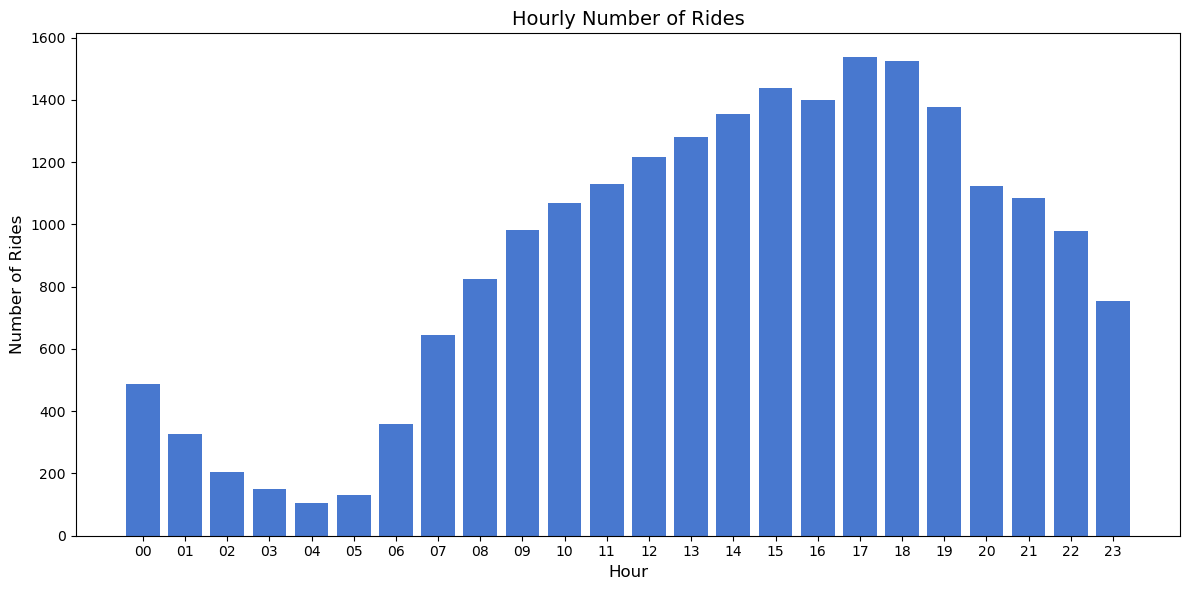

In [70]:
plot_taxi_popular_hour(df_results1)

### Visualization 2

In [21]:
def create_plot():
    raise NotImplementedError()

In [294]:
def get_data_for_visual_2():
    # Query SQL database for the data needed.
    # You can put the data queried into a pandas dataframe, if you wish
    raise NotImplementedError()

In [295]:
some_dataframe = get_data_for_visual_2()
plot_visual_1(some_dataframe)

NotImplementedError: 

### Visualization 3
This analysis aims to find out the most popular day of the week for rides ending at NYC’s three major airports: LGA, JFK, and EWR by visualizing the popularity. The data spans from January 2020 to August 2024, including rides from both Yellow Taxi and Uber.

* In the function `get_data_for_visual_3`, a SQL query was made including the following: 
    * Drop-off locations  matched to airports based on the latitude and longitude boundaries
    * Aggregated the count of drop-offs by airport and day of the week
* The function `plot_airport_popularity` creates the bar plot, and numeric values are mapped to descriptive strings of days in week.

This plot highlights the general popularity between the three airports, and also shows the trend of popularity of drop offs between different days of a week.

In [64]:
def get_data_for_visual_3(engine) -> pd.DataFrame:
    """
    Query the database to get the number of drop-offs for each airport by day of the week.

    Args:
        engine (sqlalchemy.engine.Engine): Database connection engine.

    Returns:
        pd.DataFrame: DataFrame with columns ['airport', 'day_of_week', 'dropoff_count'].
    """
    query = """
    WITH airport_dropoffs AS (
        SELECT 
            "tpep_pickup_datetime" AS trip_datetime,
            "latitude_dropoff" AS dropoff_lat,
            "longitude_dropoff" AS dropoff_lon
        FROM taxi_trips

        UNION ALL

        SELECT 
            "pickup_datetime" AS trip_datetime,
            "dropoff_lat",
            "dropoff_lon"
        FROM uber_trips
    ),
    airport_assignments AS (
        SELECT
            CASE
                WHEN dropoff_lat BETWEEN 40.763589 AND 40.778865 
                     AND dropoff_lon BETWEEN -73.891745 AND -73.854838 THEN 'LGA'
                WHEN dropoff_lat BETWEEN 40.639263 AND 40.651376 
                     AND dropoff_lon BETWEEN -73.795642 AND -73.766264 THEN 'JFK'
                WHEN dropoff_lat BETWEEN 40.686794 AND 40.699680 
                     AND dropoff_lon BETWEEN -74.194028 AND -74.165205 THEN 'EWR'
                ELSE NULL
            END AS airport,
            strftime('%w', trip_datetime) AS day_of_week
        FROM airport_dropoffs
        WHERE dropoff_lat IS NOT NULL AND dropoff_lon IS NOT NULL
    ),
    airport_weekday_counts AS (
        SELECT
            airport,
            day_of_week,
            COUNT(*) AS dropoff_count
        FROM airport_assignments
        WHERE airport IS NOT NULL
        GROUP BY airport, day_of_week
    )
    SELECT 
        airport,
        day_of_week,
        dropoff_count
    FROM airport_weekday_counts
    ORDER BY airport, dropoff_count DESC, day_of_week;
    """

    with engine.connect() as connection:
        result = connection.execute(db.text(query))
        df = pd.DataFrame(result.fetchall(), columns=["airport", "day_of_week", "dropoff_count"])
    
    return df

In [65]:
def plot_airport_popularity(df: pd.DataFrame) -> None:
    """
    Create a visualization that compares what day of the week was most popular for drop-offs
    at each airport between January 2020 and August 2024, inclusive.

    Args:
        df (pd.DataFrame): DataFrame with columns ['airport', 'day_of_week', 'dropoff_count'].
    """
    # Map numeric values to days of week
    day_mapping = {
        "0": "Sunday", "1": "Monday", "2": "Tuesday", "3": "Wednesday",
        "4": "Thursday", "5": "Friday", "6": "Saturday"
    }
    df["day_of_week"] = df["day_of_week"].astype(str).map(day_mapping)

    day_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=df,
        x="day_of_week",
        y="dropoff_count",
        hue="airport",
        order=day_order
    )
    plt.title("Airport Dropoff Popularity", fontsize=16)
    plt.xlabel("Day of the Week", fontsize=14)
    plt.ylabel("Drop-Off Count", fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    plt.legend(title="Airport", fontsize=12, title_fontsize=14)
    plt.tight_layout()
    plt.show()

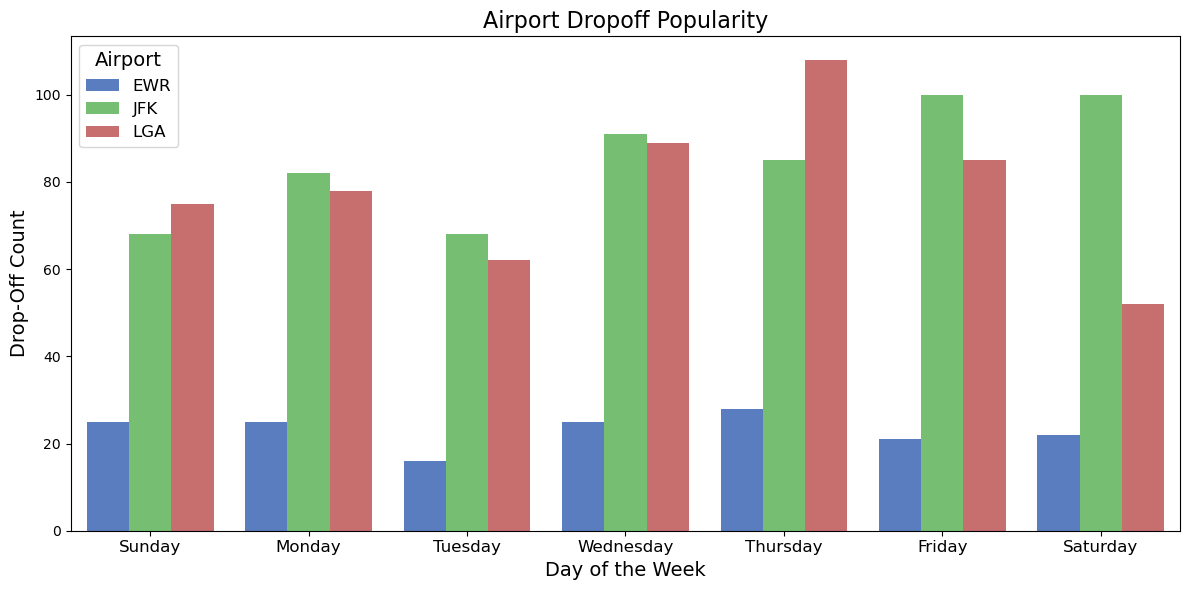

In [66]:
airport_dropoff_df = get_data_for_visual_3(engine)
plot_airport_popularity(airport_dropoff_df)

### Visualization 5
This visualization analyzes and compares the tip amounts for Yellow Taxi and Uber rides over the years 2022 and 2023. The comparison is conducted with respect to trip distance and daily precipitation, thus we can conclude whether Taxi and Uber tips are correlated with precipitation amount and trip distance. 

* `get_data_for_visual_5` is a function that queries the database to get information needed for visualization and write data into dataframes
* `plot_tip_comparison` creates the scatter plots. Prior to creating the plot, rides with extreme trip distances (> 50 miles) are excluded to improve the visualization clarity and ensure the plots are representative of typical rides.

In [48]:
def get_data_for_visual_5(engine) -> (pd.DataFrame, pd.DataFrame):
    """
    Gets data relevant to Yellow Taxi and Uber rides with distance, tips and precipitation between 
    2022 and 2023.

    Args:
        engine: SQLAlchemy database engine.

    Returns:
        tuple: Two DataFrames, one for taxi data and one for Uber data.
    """
    taxi_query = """
    SELECT 
        tt.tpep_pickup_datetime AS trip_datetime,
        tt.trip_distance,
        tt.tip_amount,
        dw.daily_precipitation
    FROM taxi_trips tt
    LEFT JOIN daily_weather dw 
        ON DATE(tt.tpep_pickup_datetime) = DATE(dw.date)
    WHERE strftime('%Y', tt.tpep_pickup_datetime) IN ('2022', '2023');
    """

    uber_query = """
    SELECT 
        ut.pickup_datetime AS trip_datetime,
        ut.trip_miles AS trip_distance,
        ut.tips AS tip_amount,
        dw.daily_precipitation
    FROM uber_trips ut
    LEFT JOIN daily_weather dw 
        ON DATE(ut.pickup_datetime) = DATE(dw.date)
    WHERE strftime('%Y', ut.pickup_datetime) IN ('2022', '2023');
    """

    with engine.connect() as connection:
        taxi_df = pd.read_sql_query(taxi_query, connection)
        uber_df = pd.read_sql_query(uber_query, connection)

    return taxi_df, uber_df

In [62]:
def plot_tip_comparison(taxi_df: pd.DataFrame, uber_df: pd.DataFrame) -> None:
    """
    Create 2*2 grid scatter plots showing the comparison of Taxi and Uber tips with daily precipitation 
    and trip distance respectively.

    Args:
        taxi_df (pd.DataFrame): DataFrame containing Yellow Taxi ride data with columns:
                                ['trip_distance', 'tip_amount', 'daily_precipitation'].
        uber_df (pd.DataFrame): DataFrame containing Uber ride data with columns:
                                ['trip_distance', 'tip_amount', 'daily_precipitation'].
    """
    # filter outliers
    taxi_df = taxi_df[taxi_df["trip_distance"] < 50]
    uber_df = uber_df[uber_df["trip_distance"] < 50]
    
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle("2022-2023 Tips Comparison for Taxi and Uber Rides", fontsize=16)

    # 1: Taxi Tips vs Distance 
    axs[0, 0].scatter(taxi_df["trip_distance"], taxi_df["tip_amount"], alpha=0.6, label="Yellow Taxi")
    axs[0, 0].set_title("Tips vs Distance (Yellow Taxi)", fontsize=14)
    axs[0, 0].set_xlabel("Distance (miles)", fontsize=12)
    axs[0, 0].set_ylabel("Tip Amount ($)", fontsize=12)
    axs[0, 0].grid(True)

    # 2: Uber Tips vs Distance 
    axs[0, 1].scatter(uber_df["trip_distance"], uber_df["tip_amount"], alpha=0.6, label="Uber")
    axs[0, 1].set_title("Tips vs Distance (Uber)", fontsize=14)
    axs[0, 1].set_xlabel("Distance (miles)", fontsize=12)
    axs[0, 1].set_ylabel("Tip Amount ($)", fontsize=12)
    axs[0, 1].grid(True)

    # 3: Taxi Tips vs Precipitation
    axs[1, 0].scatter(taxi_df["daily_precipitation"], taxi_df["tip_amount"], alpha=0.6, label="Yellow Taxi")
    axs[1, 0].set_title("Tips vs Precipitation (Yellow Taxi)", fontsize=14)
    axs[1, 0].set_xlabel("Daily Precipitation (inches)", fontsize=12)
    axs[1, 0].set_ylabel("Tip Amount ($)", fontsize=12)
    axs[1, 0].grid(True)

    # 4: Uber Tips vs Precipitation 
    axs[1, 1].scatter(uber_df["daily_precipitation"], uber_df["tip_amount"], alpha=0.6, label="Uber")
    axs[1, 1].set_title("Tips vs Precipitation (Uber)", fontsize=14)
    axs[1, 1].set_xlabel("Daily Precipitation (inches)", fontsize=12)
    axs[1, 1].set_ylabel("Tip Amount ($)", fontsize=12)
    axs[1, 1].grid(True)

    plt.tight_layout() 
    plt.show()

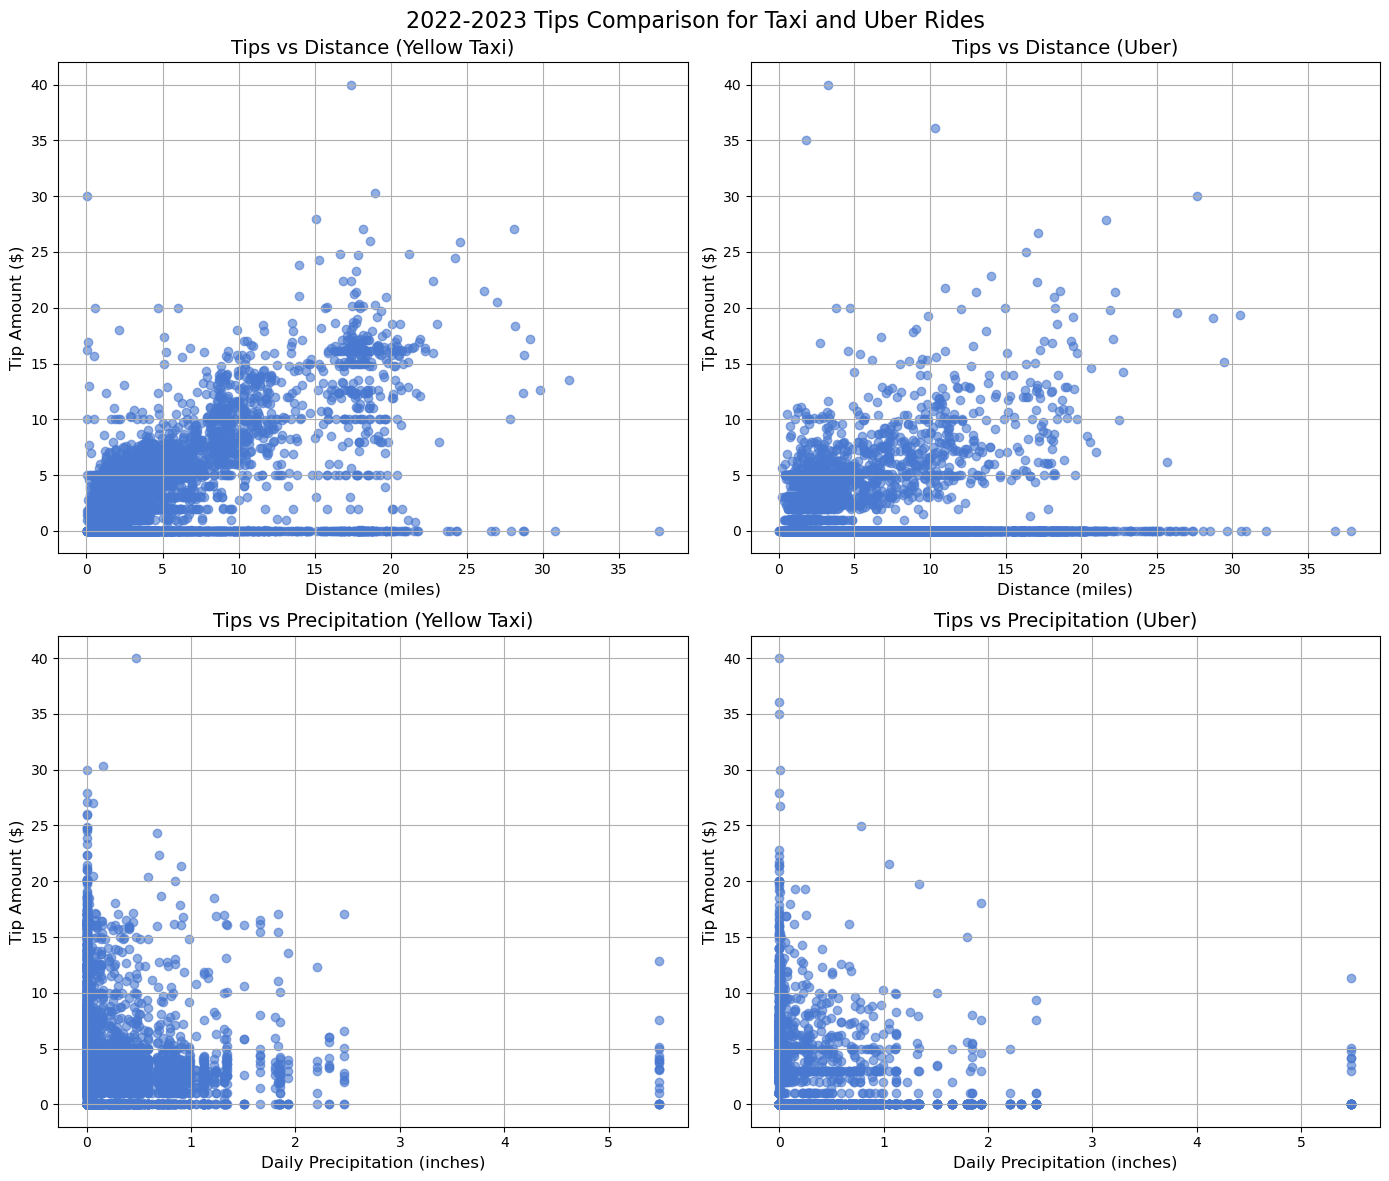

In [63]:
taxi_tip_df, uber_tip_df = get_data_for_visual_5(engine)
plot_tip_comparison(taxi_tip_df, uber_tip_df)